# 사용자 행동 예측
- 사용자 행동 인식 데이터
- 30명에게 스마트폰 센서 장착 후, 동작과 관련된 여러 피처 수집
- 결정트리를 이용하여 동작 예측

- 행동
    1. WALKING
    1. WALKING_UPSTAIRS
    1. WALKING_DOWNSTAIRS
    1. SITTING
    1. STANDING
    1. LAYING

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

## 파일 읽어오기

In [2]:
feature = pd.read_csv('uci_human_activity/features.txt', sep=' ', index_col=0, names=['feature'])
feature

,feature
1,tBodyAcc-mean()-X
2,tBodyAcc-mean()-Y
3,tBodyAcc-mean()-Z
4,tBodyAcc-std()-X
5,tBodyAcc-std()-Y
...,...
557,"angle(tBodyGyroMean,gravityMean)"
558,"angle(tBodyGyroJerkMean,gravityMean)"
559,"angle(X,gravityMean)"
560,"angle(Y,gravityMean)"


### 학습 데이터와 테스트 데이터 로딩

In [ ]:
# 학습 데이터와 테스트 데이터 읽어오기
x_train = pd.read_csv('uci_human_activity/train/X_train.txt', sep='\s+', header=None)
x_train.columns = feature['feature'].values
x_train[:2]

In [171]:
x_test = pd.read_csv('uci_human_activity/test/X_test.txt', sep='\s+', header=None)
x_test.columns = feature['feature'].values
x_test[:2]

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,...,"fBodyGyro-bandsEnergy()-25,48_2",fBodyAccMag-mean(),fBodyAccMag-std(),fBodyAccMag-mad(),fBodyAccMag-max(),fBodyAccMag-min(),fBodyAccMag-sma(),fBodyAccMag-energy(),fBodyAccMag-iqr(),fBodyAccMag-entropy(),fBodyAccMag-maxInds,fBodyAccMag-meanFreq(),fBodyAccMag-skewness(),fBodyAccMag-kurtosis(),fBodyBodyAccJerkMag-mean(),fBodyBodyAccJerkMag-std(),fBodyBodyAccJerkMag-mad(),fBodyBodyAccJerkMag-max(),fBodyBodyAccJerkMag-min(),fBodyBodyAccJerkMag-sma(),fBodyBodyAccJerkMag-energy(),fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,-0.554577,-0.466223,0.717208,0.635502,0.789497,-0.877764,-0.997766,-0.998414,-0.934345,-0.975669,-0.949824,-0.830478,-0.168084,-0.378996,0.246217,0.521204,-0.487793,0.482280,-0.045462,0.211955,-0.134894,0.130858,-0.014176,-0.105971,0.073544,-0.171516,0.040063,0.076989,-0.490546,-0.709003,0.936489,-0.282719,0.115288,-0.925427,-0.937014,-0.564288,-0.93002,-0.937822,-0.605588,0.906083,-0.279244,0.152895,0.944461,-0.26216,-0.076162,-0.017827,0.829297,-0.864621,-0.967795,-0.949727,...,-0.998290,-0.790946,-0.711074,-0.726707,-0.777697,-0.944881,-0.790946,-0.953984,-0.873543,-0.174593,-1.000000,-0.483453,0.011041,-0.384517,-0.895061,-0.896360,-0.888197,-0.928466,-0.898100,-0.895061,-0.993471,-0.921477,-0.484619,-1.0,-0.035356,-0.254248,-0.700326,-0.770610,-0.797113,-0.764485,-0.820188,-0.937959,-0.770610,-0.970958,-0.798387,0.179435,-1.0,-0.047391,-0.467849,-0.761326,-0.890165,-0.907308,-0.895301,-0.917883,-0.909829,-0.890165,-0.994105,-0.898022,-0.234815,-1.0,0.071645,-0.330370,-0.705974,0.006462,0.16292,-0.825886,0.271151,-0.720009,0.276801,-0.057978
1,0.286027,-0.013163

In [172]:
y_train = pd.read_csv('uci_human_activity/train/y_train.txt', names=['value'])
y_train

,value
0,5
1,5
2,5
3,5
4,5
...,...
7347,2
7348,2
7349,2
7350,2


In [173]:
y_test = pd.read_csv('uci_human_activity/test/y_test.txt', names=['value'])
y_test

,value
0,5
1,5
2,5
3,5
4,5
...,...
2942,2
2943,2
2944,2
2945,2


### 전처리
- 중복된 피처명 처리

In [174]:
def duplicate(fun):
    duplicates = fun.columns.duplicated(keep=False)

    # 중복된 컬럼명에 숫자 추가하여 컬럼명 변경
    count_dict = {}
    for i, col in enumerate(fun.columns):
        if duplicates[i]:
            if col in count_dict:
                count_dict[col] += 1
            else:
                count_dict[col] = 0
            fun.columns.values[i] = f'{col}_{count_dict[col]}'

In [175]:
duplicate(x_train)
duplicate(x_test)

## 결정트리

### 하이퍼파라미터 : default
- DecisionTreeClassifier

In [176]:
dt_clf = DecisionTreeClassifier(random_state=11)

dt_clf.fit(x_train, y_train)

pred = dt_clf.predict(x_test)

accuracy = accuracy_score(y_test, pred)
accuracy

0.8612147947064812

In [178]:
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, 
                out_file='activity_tree.dot', 
                class_names=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING'], 
                feature_names=feature['feature'].values, 
                filled=True,
               )

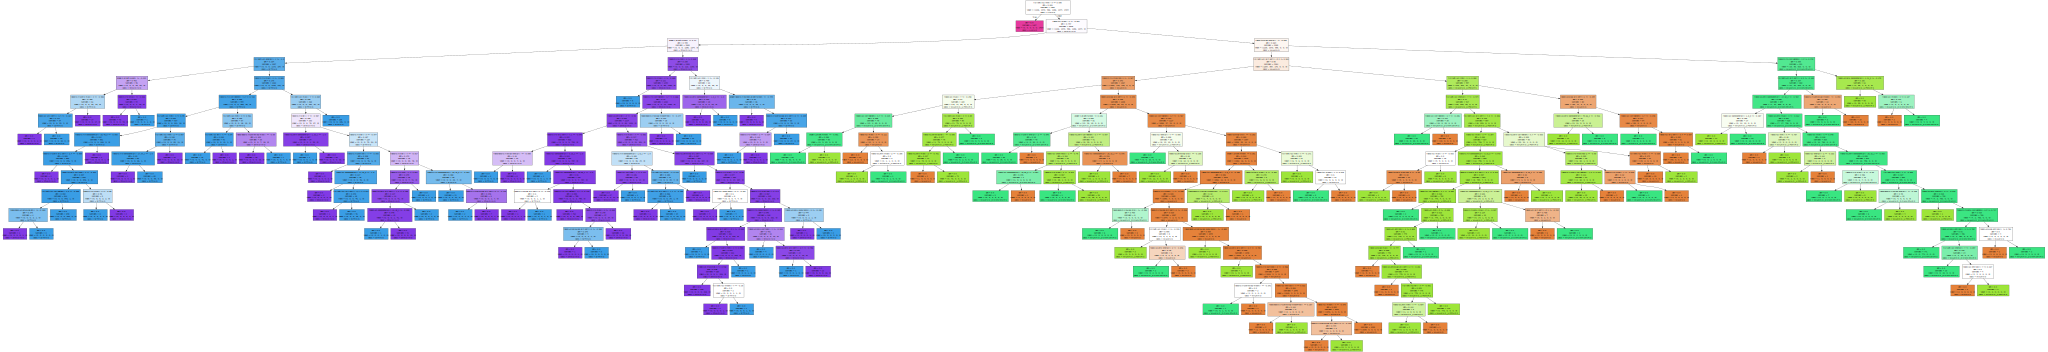

In [180]:
import graphviz

with open('activity_tree.dot') as file:
    graph = file.read()
    
graphviz.Source(graph)

### 하이퍼파라미터 : 알아서 max_depth, min_samples_split, min_samples_leaf 등 
- GridSearchCV

In [188]:
dt_clf = DecisionTreeClassifier(random_state=11)

parameter = {'max_depth' : [7, 10, 12], 'min_samples_split': [2, 3], 'min_samples_leaf' : [1, 5]}

grid_search = GridSearchCV(dt_clf, param_grid=parameter, cv=5, return_train_score=True)

grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=11),
             param_grid={'max_depth': [7, 10, 12], 'min_samples_leaf': [1, 5],
                         'min_samples_split': [2, 3]},
             return_train_score=True)

In [189]:
grid_search.best_params_

{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [190]:
grid_search.best_score_

0.8488914478095794

In [191]:
grid_search.cv_results_

{'mean_fit_time': array([1.53522406, 1.56584311, 1.55028477, 1.55525031, 2.00708008,
        2.0370348 , 1.99387898, 1.98764715, 2.31726203, 2.28882976,
        2.1035593 , 2.09942255]),
 'std_fit_time': array([0.02399249, 0.02292642, 0.01953767, 0.02354077, 0.07334213,
        0.06530998, 0.04426117, 0.04512592, 0.11947802, 0.11688418,
        0.11605931, 0.11563294]),
 'mean_score_time': array([0.006001  , 0.00640111, 0.00630245, 0.00638499, 0.00620084,
        0.00600114, 0.00640116, 0.00620046, 0.00720191, 0.00630212,
        0.00580263, 0.0062006 ]),
 'std_score_time': array([5.43678010e-07, 4.90232440e-04, 4.00534374e-04, 4.71373745e-04,
        3.99089582e-04, 8.86968386e-07, 4.89414718e-04, 4.00472408e-04,
        1.47039199e-03, 4.00723434e-04, 2.43043062e-04, 4.00520006e-04]),
 'param_max_depth': masked_array(data=[7, 7, 7, 7, 10, 10, 10, 10, 12, 12, 12, 12],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, F